In [116]:
#import libraries and set the vectorBT portfolio settings

import numpy as np
import pandas as pd

np.random.seed(42)

In [117]:
import datetime as dt
# Tirei a CIEL3, pois ela não está mais sendo negociada

# ativos = pd.read_csv("./data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('./data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']

# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('./data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

prices = prices[(prices.index <= dt.datetime(2023, 12, 30)) & (prices.index >= dt.datetime(2017, 1, 1))]

In [118]:
limite_superior = 75
limite_inferior = 25

# Treino = Resto dos dados
# CV = 1 ano
# Teste = 1 ano

# K-fold = 2021, 2022, 2023

reotimizar = True

sinal = pd.Series(index=indicadores.index)
for data, indicador in indicadores.items():
    if (indicador > limite_superior or indicador < limite_inferior):
        if reotimizar:
            sinal.loc[data] = 1
        else:
            sinal.loc[data] = 0
        reotimizar = False
    else:
        sinal.loc[data] = 0
        reotimizar = True

indicadores_sinal = pd.concat([indicadores, sinal], axis=1)

In [119]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores_sinal.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores_sinal = indicadores_sinal.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores_sinal.index)) # Deve retornar True se estiverem alinhados


True


In [ ]:
import riskfolio as rp
import pandas as pd

# Função para obter os dias úteis
def get_business_days(prices):
    start_date = prices.index[0]
    end_date = prices.index[-1]
    
    # Lista para armazenar as datas
    dates = []
    current_date = start_date
    
    while current_date <= end_date:
        # Se a data atual não for dia útil, ajusta para o próximo dia útil
        if current_date.weekday() >= 5:  # Sábado (5) ou domingo (6)
            current_date += pd.offsets.BDay()
        
        # Adiciona a data ajustada à lista
        dates.append(current_date)
        
        # Avança 3 meses
        current_date += pd.DateOffset(days=15)
    
    # Cria uma Series com essas datas como índice e valores True
    rebalancear_trimestres = pd.Series(index=dates, data=True)
    rebalancear_trimestres = rebalancear_trimestres.reindex(prices.index, fill_value=False)
    
    return rebalancear_trimestres


def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # hist, ledoit, ewma (suavização exponencial)

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)


prices.sort_index(inplace=True)
prices_limite = prices[get_business_days(prices)]
prices_limite
# pesos = pd.Series(index=prices_limite.index)
# for data, entry in prices_limite.iterrows():
#     if not entry.isna().any():
#         w = optimization(prices, data).T
#         w.index = [data]
#         pesos = pd.concat([pesos, w], axis=0)

# pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,12.610021,7.343465,8.468404,10.343587,10.005226,9.014327,2.468536,45.596249,25.145233,12.471114,...,10.522023,5.473835,7.216786,8.455055,12.650480,3.196681,14.526073,20.882462,5.142142,12.949368
2017-01-17,13.298122,7.522574,8.892747,11.326577,11.131193,9.059777,3.278896,44.120796,26.025316,12.439522,...,10.792450,6.012012,7.850049,8.908404,12.352382,3.698121,17.719954,21.661795,5.278357,14.466416
2017-02-01,13.445174,7.634517,9.612288,11.502547,11.273723,9.120379,3.699399,41.693439,23.821411,12.249968,...,10.694115,6.288183,7.999952,8.711867,12.026340,4.113376,19.064743,22.252192,5.377112,13.016421
2017-02-16,13.949757,8.865891,10.113499,11.440477,11.471631,9.052201,3.849214,41.788628,24.509205,14.572012,...,10.733446,6.953822,7.908175,8.870405,12.797662,4.277911,19.574839,22.641857,5.704031,12.446482
2017-03-03,13.499515,8.888279,10.733693,11.504192,11.756637,8.143195,3.893476,38.276100,23.658705,14.374559,...,11.244799,7.067124,8.162095,8.904475,12.232579,4.066366,18.444515,21.974646,6.053657,12.697925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17,12.164180,7.340000,23.221672,11.769829,13.250895,7.800000,20.309021,10.610000,18.870001,11.833264,...,30.399370,14.443419,26.331596,19.978722,19.340866,5.993291,62.040108,43.370731,33.659046,18.852673
2023-11-01,12.344742,8.570000,22.770035,11.574748,12.912537,7.600000,21.575466,11.140000,16.520000,11.978516,...,30.880892,14.856355,25.878284,19.713072,20.697266,6.515287,64.298607,45.168613,32.480785,17.722887
2023-11-16,12.990964,9.790000,23.654491,12.828014,14.257697,7.210000,23.511845,13.860000,19.809999,13.251979,...,33.473068,15.851156,32.944061,24.018435,24.063864,7.327281,67.754936,48.152618,32.873535,20.002106


In [121]:
import riskfolio as rp
import pandas as pd

# TODO: Constraints da otimização
# Restrições:
# - No max 25% em um ativo
# - Usar estudo do artigo

def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # hist, ledoit, ewma (suavização exponencial)

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores_sinal.loc[indicadores_sinal[0] == 1, 0]
indicadores_limite.sort_index(inplace=True)


pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2017-05-19,3.878559e-02,1.619331e-02,5.499919e-10,2.690047e-09,2.330342e-09,5.469781e-02,1.115673e-09,2.325844e-02,3.735723e-02,1.952300e-09,...,0.041810,3.962407e-02,4.481080e-02,0.039919,4.043581e-02,4.882820e-10,5.373920e-03,0.035334,2.379200e-02,1.794130e-09
2018-06-08,7.605125e-02,1.319455e-02,8.116718e-10,1.888202e-09,2.152692e-09,6.239294e-02,2.037749e-09,6.403081e-09,2.304262e-02,2.771670e-09,...,0.046110,7.367761e-03,4.821510e-02,0.061778,3.465735e-02,6.634298e-10,3.977661e-03,0.058332,5.746453e-03,1.008364e-09
2018-08-14,8.250142e-02,8.272641e-03,1.224748e-10,2.458341e-10,2.638061e-10,5.613279e-02,2.753628e-10,1.410959e-09,3.188762e-02,5.617667e-10,...,0.044213,2.252881e-03,4.947929e-02,0.062942,2.639700e-02,9.676290e-11,6.286490e-03,0.056539,4.930638e-03,1.689432e-10
2018-08-24,8.568187e-02,7.025467e-03,1.431807e-10,2.763907e-10,2.970872e-10,5.609596e-02,3.273675e-10,1.543473e-09,3.162679e-02,5.818241e-10,...,0.045585,6.867834e-04,4.872018e-02,0.063281,2.578455e-02,1.162649e-10,4.639244e-03,0.057150,5.120114e-03,1.893753e-10
2018-08-29,8.633559e-02,7.173622e-03,1.142826e-09,2.251246e-09,2.421880e-09,5.635132e-02,2.603031e-09,1.233462e-08,3.205396e-02,4.785817e-09,...,0.045545,1.578281e-05,4.885402e-02,0.063092,2.504001e-02,9.249465e-10,4.388081e-03,0.057971,4.849954e-03,1.523098e-09
2018-09-04,8.696987e-02,5.339109e-03,7.317200e-11,1.330106e-10,1.397972e-10,5.637901e-02,1.651089e-10,5.523909e-10,3.194688e-02,2.420087e-10,...,0.046493,4.409000e-08,4.918826e-02,0.062129,2.196443e-02,6.005144e-11,3.605802e-03,0.058842,6.668974e-03,9.350250e-11
2018-09-11,8.801682e-02,3.926349e-03,1.006159e-09,1.919148e-09,2.057305e-09,5.651896e-02,2.318213e-09,1.088711e-08,3.215067e-02,4.422894e-09,...,0.045975,3.623591e-04,4.820943e-02,0.062358,2.310116e-02,8.214274e-10,3.213414e-03,0.057642,4.580073e-03,1.330100e-09
2020-01-15,5.815080e-02,4.265091e-03,1.057894e-09,1.299839e-09,1.903555e-09,8.525905e-04,2.662382e-09,3.891541e-08,1.582024e-02,3.413733e-09,...,0.033612,3.772495e-09,3.804771e-02,0.092508,1.580155e-09,7.657645e-10,3.489516e-02,0.082336,6.062353e-03,9.469816e-10
2020-03-16,3.253404e-02,1.890697e-10,1.045355e-10,1.299735e-10,1.711694e-10,1.613838e-10,1.918684e-10,1.732920e-10,1.141169e-10,9.061881e-11,...,0.213579,1.602361e-09,4.907403e-10,0.166670,7.164939e-11,1.000492e-10,2.277208e-10,0.128431,3.191717e-10,1.793902e-10
2020-10-22,1.101622e-03,3.904136e-11,2.886191e-11,4.081091e-11,4.523497e-11,7.562060e-11,2.598349e-10,4.684042e-11,1.590124e-11,2.479492e-11,...,0.362125,1.529152e-10,1.086063e-10,0.166760,1.650735e-11,2.593415e-11,1.451362e-10,0.088578,8.701543e-11,3.383768e-11


c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


<Axes: title={'center': 'Equity Progression'}>

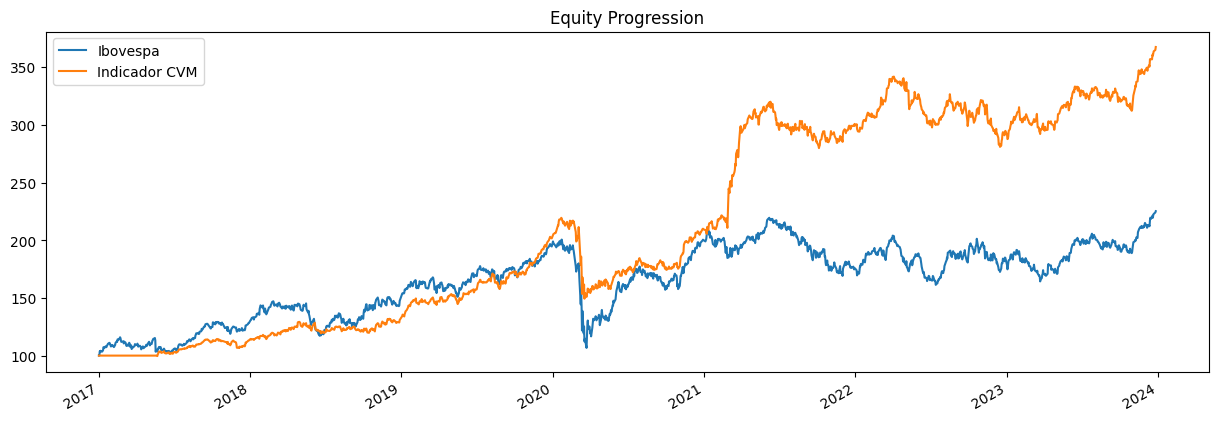

In [ ]:
import bt
import yfinance as yf

prices = prices[prices.index >= indicadores.index.min()]

# Medir turnover (o quanto seus pesos mudam ao longo do tempo)

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))[['Adj Close']]

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# # Estratégia CVM trimestral
# strat_cvm_trimestral = bt.Strategy('CVM Trimestral', [
#     bt.algos.WeighTarget(pesos_trimestrais),
#     bt.algos.Rebalance()
# ])


# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Indicador', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])
# Criando o backtest
backtests = [
    # bt.Backtest(strat_cvm_trimestral, prices, initial_capital=1000000000),
    bt.Backtest(strat_ibov, ibov, initial_capital=1000000000),
    bt.Backtest(strat_indicador, prices, initial_capital=1000000000)
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()

In [123]:
# Resultados
results.display()

Stat                 Ibovespa    Indicador CVM
-------------------  ----------  ---------------
Start                2017-01-01  2017-01-01
End                  2023-12-27  2023-12-27
Risk-free rate       0.00%       0.00%

Total Return         125.19%     267.51%
Daily Sharpe         0.60        1.14
Daily Sortino        0.92        1.84
CAGR                 12.33%      20.49%
Max Drawdown         -46.81%     -31.94%
Calmar Ratio         0.26        0.64

MTD                  5.39%       6.20%
3m                   17.38%      14.88%
6m                   14.19%      12.40%
YTD                  21.96%      24.67%
1Y                   23.86%      26.31%
3Y (ann.)            4.08%       20.61%
5Y (ann.)            9.45%       23.35%
10Y (ann.)           -           -
Since Incep. (ann.)  12.33%      20.49%

Daily Sharpe         0.60        1.14
Daily Sortino        0.92        1.84
Daily Mean (ann.)    14.96%      20.55%
Daily Vol (ann.)     24.92%      17.96%
Daily Skew           -0.96  

In [124]:
trans = results.get_transactions("Indicador CVM")
trans

price   quantity
Date       Security                       
2017-05-19 ABEV3.SA   14.454340  2683318.0
           ALPA4.SA    8.495312  1906146.0
           BEEF3.SA    7.357272  7434523.0
           BRFS3.SA   38.504559   604043.0
           BRKM5.SA   23.237154  1607650.0
...                         ...        ...
2023-12-14 TAEE11.SA  34.128860  1345058.0
           TIMS3.SA   17.333977 -1308207.0
           TRPL4.SA   23.760000 -2126820.0
           VALE3.SA   67.781174   260815.0
           VIVT3.SA   51.649788  -129367.0

[437 rows x 2 columns]

In [125]:
import pandas as pd

opt = pd.read_csv('./data/resultados_otimization.csv')

opt.drop(columns=['Unnamed: 0'], inplace=True)

In [126]:
opt2 = opt[opt['obj'] == 'MinRisk'].reset_index(drop=True)
opt2.loc[np.argmax(opt2['total_return']), ['limite_inferior', 'limite_superior', 'obj', 'total_return']]

limite_inferior         21
limite_superior         76
obj                MinRisk
total_return       6.49831
Name: 67, dtype: object